# California Housing Prices - Input Engineering and Data Cleaning

In this notebook, we will conduct input engineering and data cleaning on the California housing dataset. 

**Key notes:**

- Missing Values Inputation
- Removing Outliers
- Adjusting Skewness
- Adding New Attributes
- One Hot Encoding
- Standard Scaling
- Feature Importance

In [1]:
import pandas as pd
import numpy as np
from scipy.special import boxcox1p 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

sns.set_style("whitegrid")

In [3]:
data = pd.read_csv("housing.csv")

In [4]:
# Split into attributes and target
attributes = data.columns.values.tolist()
attributes.remove("median_house_value")

X = data[attributes]
y = data["median_house_value"]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (20640, 9)
y shape: (20640,)


In [5]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14448, 9)
y_train shape: (14448,)
X_test shape: (6192, 9)
y_test shape: (6192,)


In [6]:
# Save data to csv files
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [7]:
# Horizontally concatenate X_train and y_train 
train = pd.concat([X_train, y_train], axis=1)
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
1989,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
256,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
7887,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
4581,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
1993,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


## Missing Values Imputation

In [8]:
train.isnull().sum().to_frame("Count of Missing Values")

,Count of Missing Values
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,137
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


There are 137 observations with missing values in the total_bedrooms column, which take 137/14448 = 0.95% of the training dataset. I personally prefer to replace missing values with median.

In [9]:
def replace_missing_values_with_median(data):
    data.fillna(data.mean(), inplace=True)
    return data

In [10]:
train = replace_missing_values_with_median(train)

In [11]:
train.isnull().sum().to_frame("Count of Missing Values")

,Count of Missing Values
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


Now there is no more missing values in the training dataset. 

## Removing Outliers

In [12]:
selected_attributes = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [13]:
def calculate_bounds(data, col):
    percentile_25 = np.percentile(data[col], 25)
    percentile_75 = np.percentile(data[col], 75)
    iqr = percentile_75 - percentile_25
    lower_bound = percentile_25 - 1.5*iqr
    upper_bound = percentile_75 + 1.5*iqr
    result = {}
    result["column"] = col
    result["lower_bound"] = round(lower_bound, 3)
    result["upper_bound"] = round(upper_bound, 3)
    return result

In [14]:
def remove_outliers(data, selected_attributes):
    results = []
    for col in selected_attributes:
        result = calculate_bounds(data, col)
        lower_bound = result.get("lower_bound")
        upper_bound = result.get("upper_bound")
        results.append(result)
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    results_df = pd.DataFrame(results)
    print(results_df)
    results_df.to_csv("bounds_by_column.csv")
    return data

In [15]:
train = remove_outliers(train, selected_attributes)
train.head()

               column  lower_bound  upper_bound
0  housing_median_age      -10.500       65.500
1         total_rooms    -1094.500     5693.500
2      total_bedrooms     -169.500     1050.500
3          population     -424.000     2720.000
4          households     -121.000      911.000
5       median_income       -0.715        7.989


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
1989,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
256,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
7887,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
1993,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0
12992,-121.26,38.69,17.0,3917.0,638.0,1809.0,564.0,5.2586,INLAND,137000.0


In [16]:
def create_boxplots_in_subplots(data, selected_attributes):
    fig = plt.figure(figsize=(20, 20), dpi=300)
    for i in range(len(selected_attributes)):
        ax = fig.add_subplot(3, 3, i+1)
        ax = sns.boxplot(y=data[selected_attributes[i]])

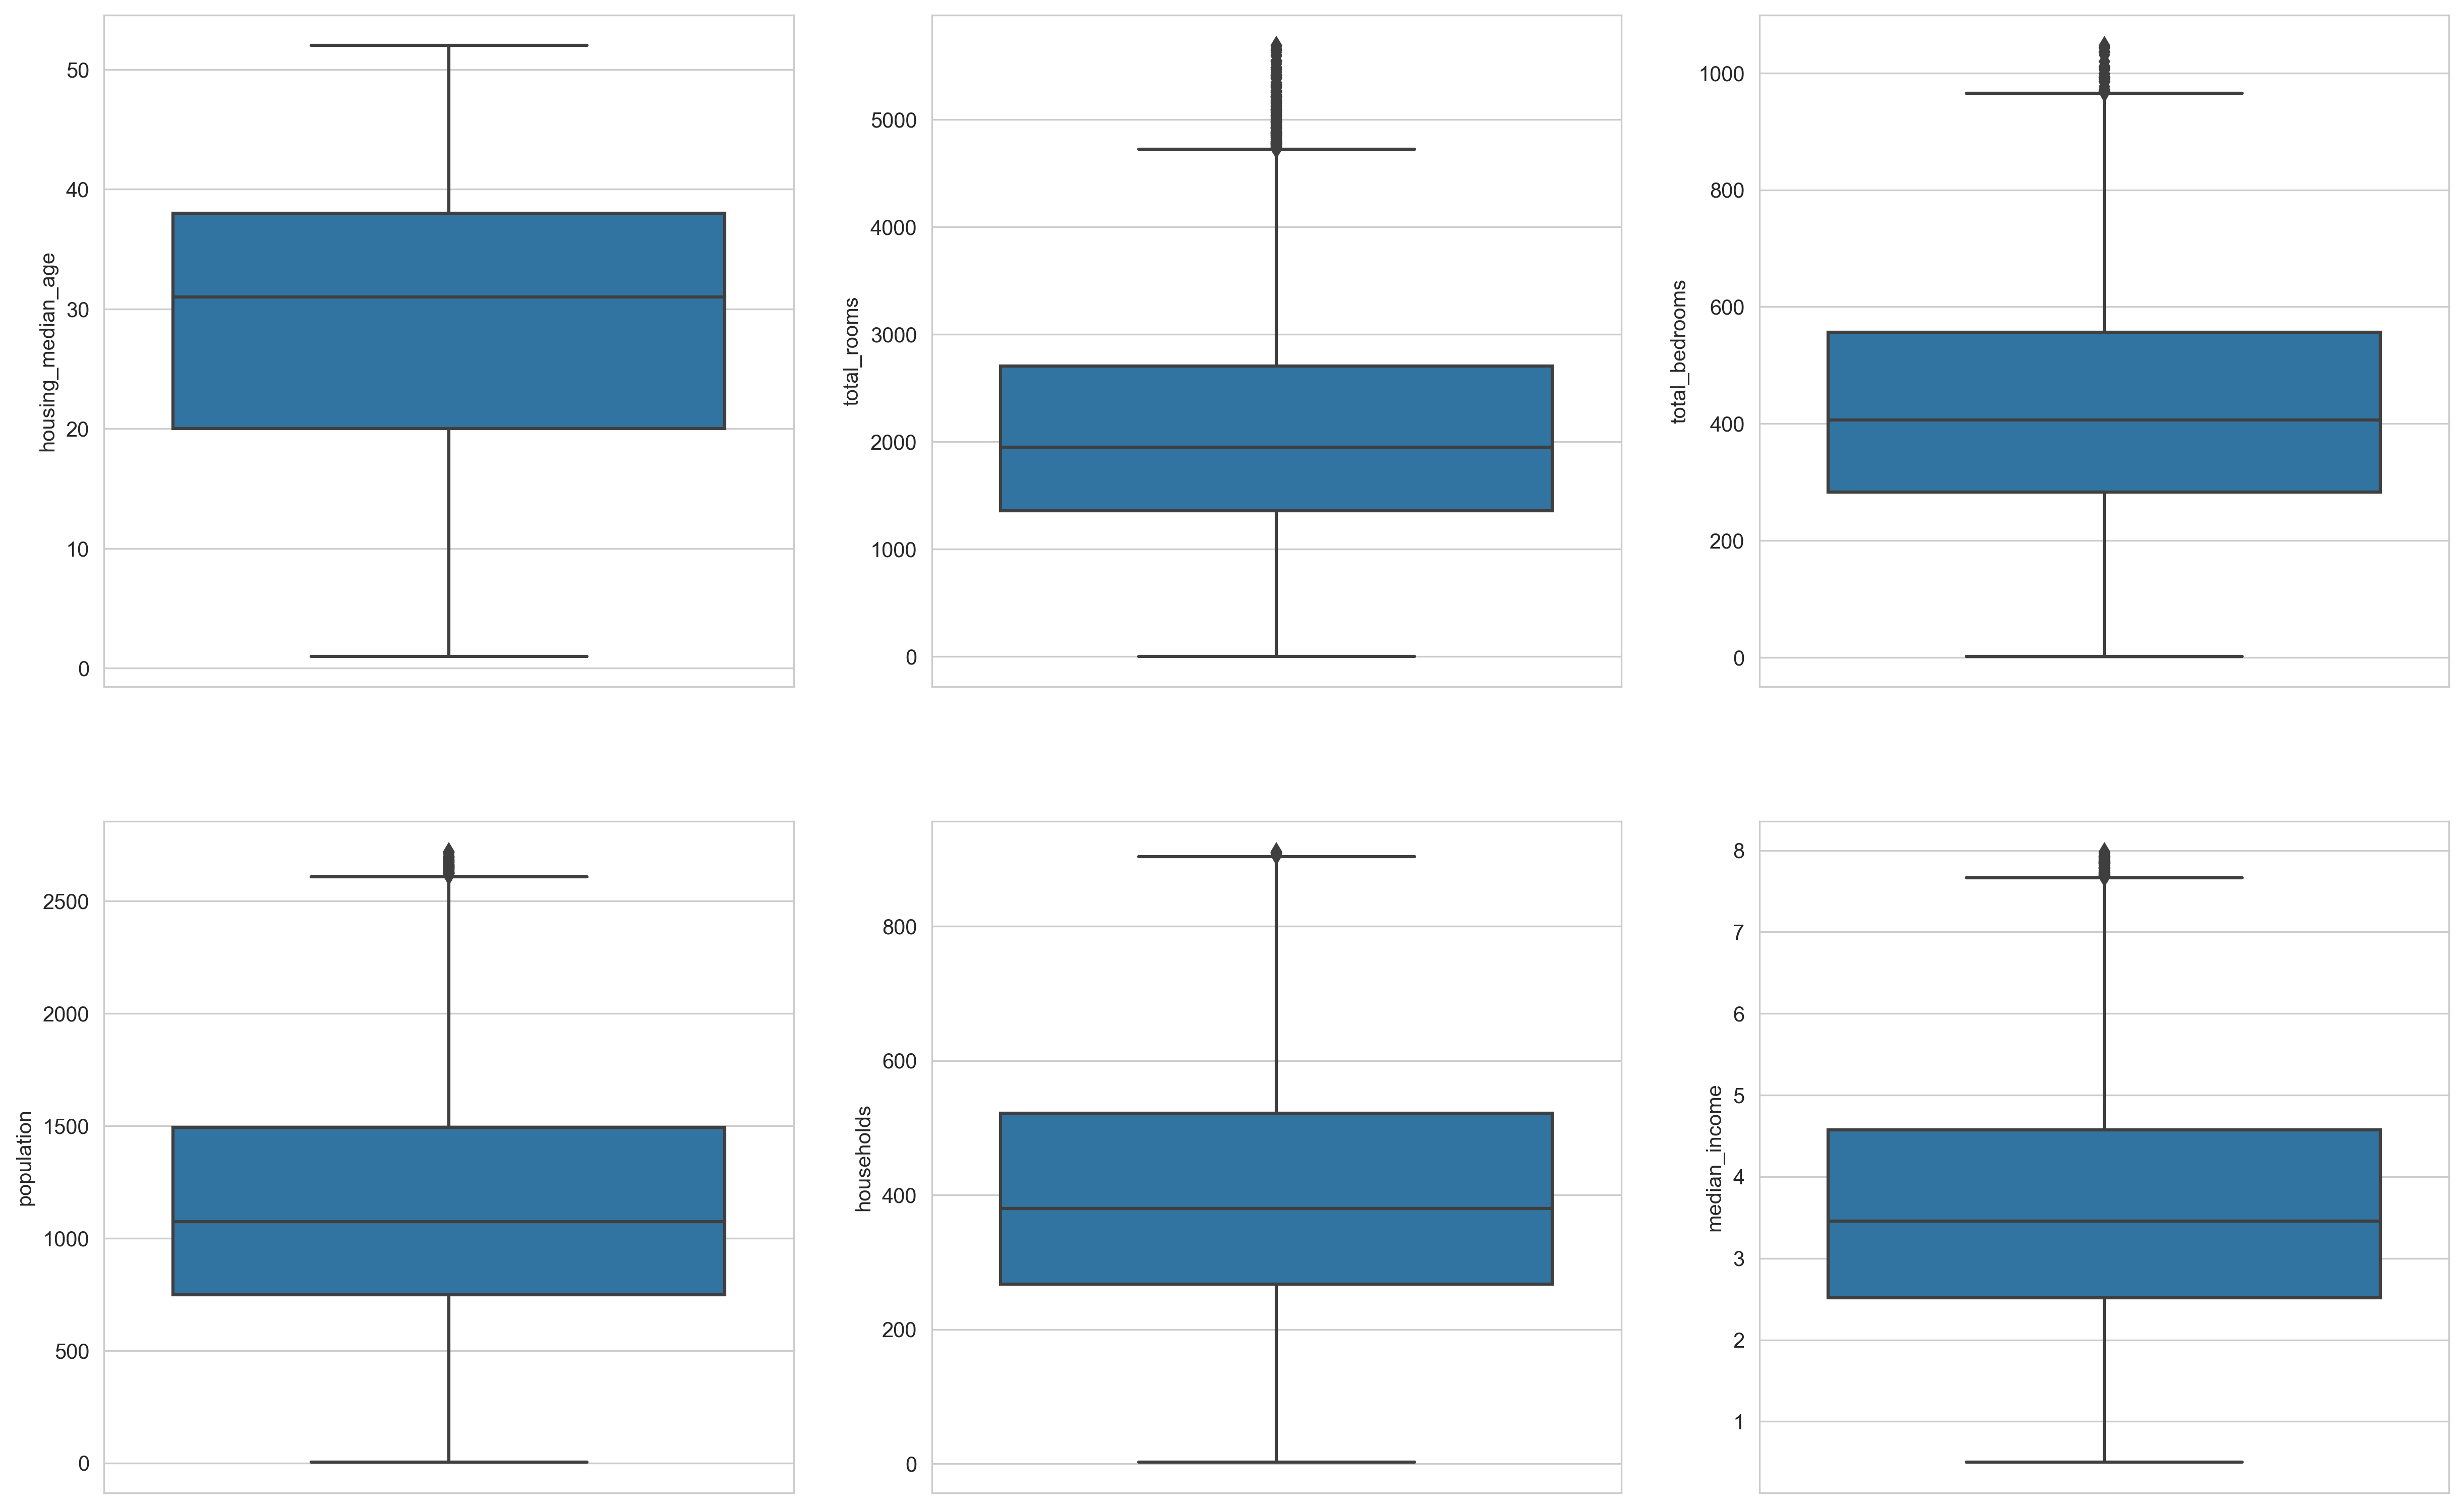

In [17]:
create_boxplots_in_subplots(train, selected_attributes)

Now all the outliers are removed.

## Adjusting Skewness

In [18]:
def get_skewness(train, selected_attributes):
    skewness_dict = {}
    for col in selected_attributes:
        skewness_dict[col] = round(train[col].skew(), 3)
    skewness_df = pd.DataFrame.from_dict(skewness_dict, orient='index').reset_index()
    skewness_df.columns = ["Column", "Skewness"]
    skewness_df.sort_values(by='Skewness', ascending=False, inplace=True)
    return skewness_df

In [19]:
skewness_df = get_skewness(train, selected_attributes)
skewness_df

,Column,Skewness
1,total_rooms,0.596
5,median_income,0.552
3,population,0.440
2,total_bedrooms,0.419
4,households,0.370
0,housing_median_age,-0.007


After trial and error, the following methods are used to adjust the skewness of each numeric attribute. 

In [20]:
def adjust_skewness(data):
    data["total_rooms"] = data["total_rooms"].apply(lambda x: boxcox1p(x, 0.62))
    data["median_income"] = data["median_income"].apply(lambda x: boxcox1p(x, 0.24))
    data['population'] = data['population'].apply(lambda x: boxcox1p(x, 0.68))
    data["total_bedrooms"] = data["total_bedrooms"].apply(lambda x: boxcox1p(x, 0.68))
    data["households"] = data["households"].apply(lambda x: boxcox1p(x, 0.72))
    return data

In [21]:
train = adjust_skewness(train)

In [22]:
skewness_df = get_skewness(train, selected_attributes)
skewness_df

,Column,Skewness
3,population,0.002
5,median_income,0.002
1,total_rooms,0.001
4,households,-0.001
0,housing_median_age,-0.007
2,total_bedrooms,-0.013


array([[<AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>],
       [<AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>]], dtype=object)

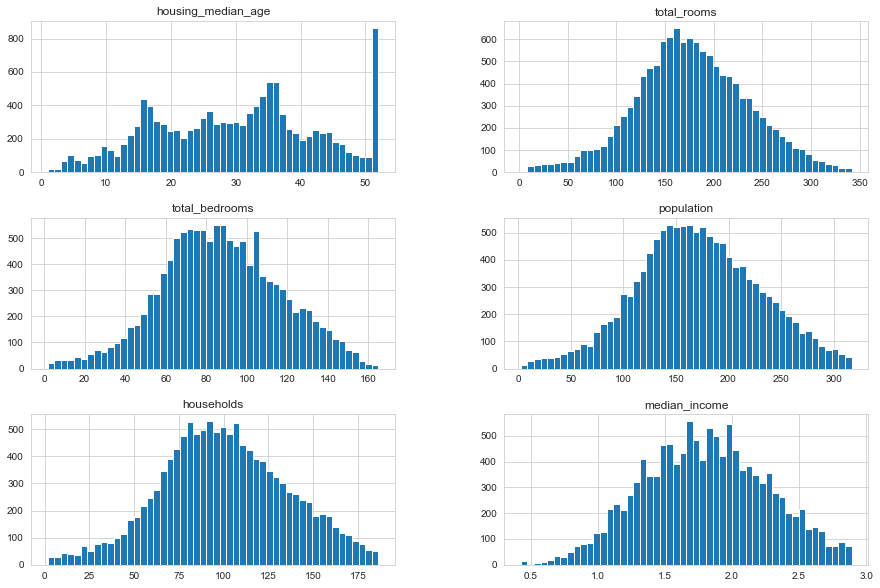

In [23]:
train[selected_attributes].hist(figsize=(15, 10), bins=50)

## Adding New Attributes

In [24]:
def add_new_attributes(data):
    data["longitude_over_latitude"] = data["longitude"] / data["latitude"]
    data["total_bedrooms_over_total_rooms"] = data["total_bedrooms"] / data["total_rooms"]
    data["population_over_total_rooms"] = data["population"] / data["total_rooms"]
    data["households_over_total_rooms"] = data["households"] / data["total_rooms"]
    data["population_over_total_bedrooms"] = data["population"] / data["total_bedrooms"]
    data["households_over_total_bedrooms"] = data["households"] / data["total_bedrooms"]
    data["population_over_households"] = data["population"] / data["households"]
    return data

In [25]:
train = add_new_attributes(train)

In [26]:
train.corr()["median_house_value"].sort_values(ascending=False)

median_house_value                 1.000000
median_income                      0.618305
total_rooms                        0.178829
housing_median_age                 0.127894
households_over_total_bedrooms     0.103622
households                         0.102283
total_bedrooms                     0.078572
longitude                         -0.036406
population                        -0.049648
households_over_total_rooms       -0.117947
latitude                          -0.158718
total_bedrooms_over_total_rooms   -0.179060
population_over_total_bedrooms    -0.194458
longitude_over_latitude           -0.217360
population_over_households        -0.256656
population_over_total_rooms       -0.299712
Name: median_house_value, dtype: float64

## One Hot Encoding

In [27]:
def one_hot_encoding(data):
    data["ocean_proximity"] = data["ocean_proximity"].str.lower()
    data = pd.get_dummies(data, columns = ["ocean_proximity"])
    return data

In [28]:
train = one_hot_encoding(train)

In [29]:
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,longitude_over_latitude,total_bedrooms_over_total_rooms,population_over_total_rooms,households_over_total_rooms,population_over_total_bedrooms,households_over_total_bedrooms,population_over_households,ocean_proximity_<1h ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near bay,ocean_proximity_near ocean
1989,-119.79,36.73,52.0,28.622582,13.047911,51.397824,18.742414,1.246179,47500.0,-3.261367,0.455861,1.795709,0.654812,3.939161,1.436430,2.742327,0,1,0,0,0
256,-122.21,37.77,43.0,116.531168,74.244825,141.400515,78.480389,1.366500,100000.0,-3.235637,0.637124,1.213414,0.673471,1.904517,1.057049,1.801731,0,0,0,1,0
7887,-118.04,33.87,17.0,197.316800,84.563118,200.048377,95.778015,2.547188,285800.0,-3.485090,0.428565,1.013844,0.485402,2.365669,1.132622,2.088667,1,0,0,0,0
1993,-119.81,36.73,50.0,97.991743,51.582983,113.360478,54.187482,1.350214,59200.0,-3.261911,0.526401,1.156837,0.552980,2.197633,1.050491,2.092005,0,1,0,0,0
12992,-121.26,38.69,17.0,270.850551,117.443051,239.915656,131.700180,2.303914,137000.0,-3.134143,0.433608,0.885786,0.486247,2.042825,1.121396,1.821681,0,1,0,0,0


## Standard Scaling

In [30]:
def standard_scaling(data):
    # Split into attributes and target 
    X = data.loc[:, ~data.columns.isin(["median_house_value"])]
    y = data.loc[:, data.columns.isin(["median_house_value"])]
    # Define standard scaler
    scaler = StandardScaler()
    # Transform data
    X_new = scaler.fit_transform(X)
    # Convert to dataframe
    X_new = pd.DataFrame(X_new, columns=X.columns)
    return X_new, y

In [31]:
X_train, y_train = standard_scaling(train)

In [32]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,longitude_over_latitude,total_bedrooms_over_total_rooms,population_over_total_rooms,households_over_total_rooms,population_over_total_bedrooms,households_over_total_bedrooms,population_over_households,ocean_proximity_<1h ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near bay,ocean_proximity_near ocean
0,-0.085055,0.474493,1.802160,-2.565368,-2.499080,-2.016213,-2.284270,-1.189034,0.656749,-0.466384,3.134813,0.898600,4.127777,2.627423,2.675156,-0.870100,1.436943,-0.012755,-0.357295,-0.385655
1,-1.290886,0.954125,1.068269,-1.043848,-0.431636,-0.487616,-0.608500,-0.929797,0.828809,1.698311,0.890962,1.088386,-0.198545,-0.834423,0.165600,-0.870100,-0.695922,-0.012755,2.798809,-0.385655
2,0.786930,-0.844495,-1.051862,0.354389,-0.083048,0.508453,-0.123267,1.614041,-0.839319,-0.792354,0.121927,-0.824502,0.782017,-0.144822,0.931160,1.149294,-0.695922,-0.012755,-0.357295,-0.385655
3,-0.095021,0.474493,1.639073,-1.364728,-1.197232,-0.963846,-1.289965,-0.964886,0.653108,0.376030,0.672946,-0.137154,0.424717,-0.894257,0.940066,-0.870100,1.436943,-0.012755,-0.357295,-0.385655
4,-0.817523,1.378415,-1.051862,1.627110,1.027751,1.185555,0.884422,1.089898,1.507510,-0.732128,-0.371538,-0.815913,0.095545,-0.247254,0.218827,-0.870100,1.436943,-0.012755,-0.357295,-0.385655


In [33]:
y_train.head()

,median_house_value
1989,47500.0
256,100000.0
7887,285800.0
1993,59200.0
12992,137000.0


## Feature Importance

In [34]:
# random forest for feature importance on a regression problem
def get_feature_importance(X_train, y_train):
    # Define the model
    model = RandomForestRegressor(random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get feature importance
    importances = model.feature_importances_
    
    # Create arrays from feature names and feature importance
    feature_names = np.array(X_train.columns)
    feature_importances = np.array(importances)

    # Create a DataFrame using a Dictionary
    fi_dict = {"feature_name": feature_names, "feature_importance": feature_importances}
    fi_df = pd.DataFrame(fi_dict)
    
    # Sort in decreasing order of feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    
    # Round the feature importance values
    fi_df["feature_importance"] = round(fi_df["feature_importance"], 3)
    
    return fi_df

In [35]:
fi_df = get_feature_importance(X_train, y_train)
fi_df

<ipython-input-34-ca5248ecee75>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


,feature_name,feature_importance
7,median_income,0.395
16,ocean_proximity_inland,0.129
14,population_over_households,0.105
0,longitude,0.060
8,longitude_over_latitude,0.055
2,housing_median_age,0.049
12,population_over_total_bedrooms,0.045
10,population_over_total_rooms,0.038
1,latitude,0.027
9,total_bedrooms_over_total_rooms,0.020


In [36]:
def create_feature_importance_barplot(fi_df, model_name):
    # Create barplot of feature importance
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    palette = sns.color_palette("Blues_r", fi_df.shape[0])
    ax = sns.barplot(data=fi_df, x="feature_importance", y="feature_name", palette=palette)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Names")
    for p in ax.patches:
        ax.annotate(format(p.get_width(), ".3f"), 
                    (p.get_width(), p.get_y()+p.get_height()), 
                    ha="left", va="center", xytext=(0, 10), textcoords="offset points")
    plt.tight_layout()
    plt.show()

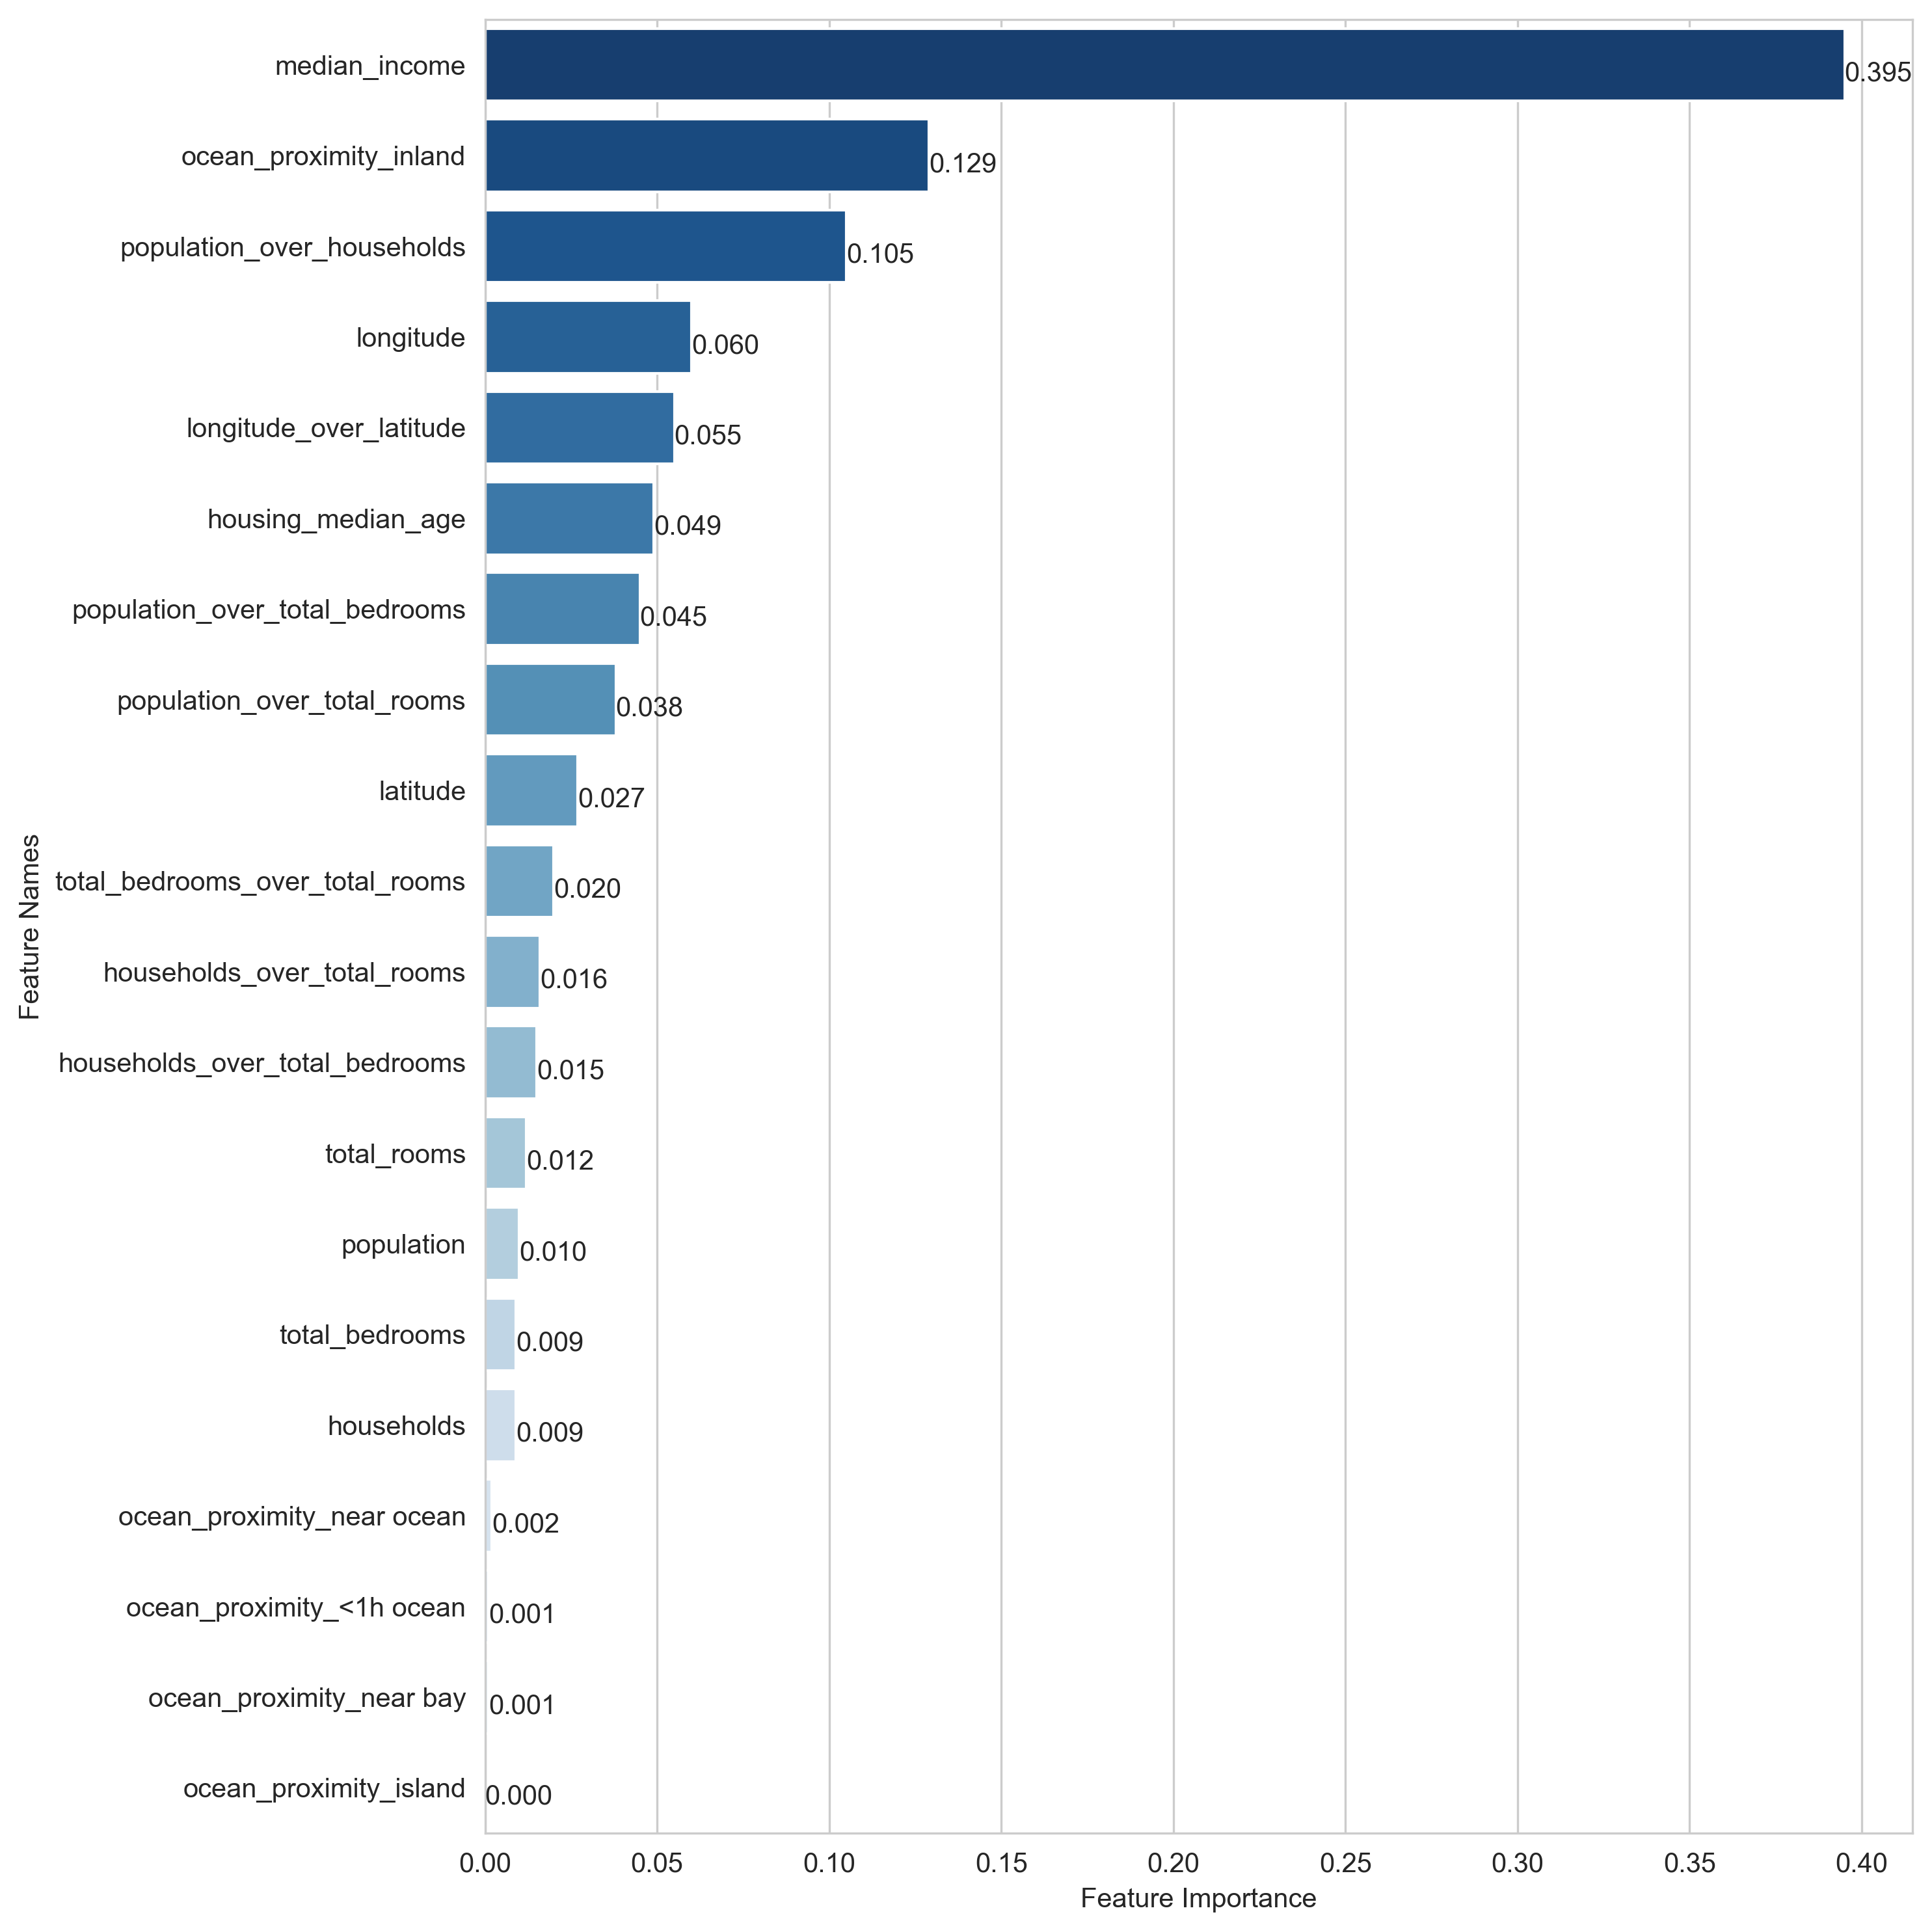

In [37]:
create_feature_importance_barplot(fi_df, model_name="Randome Forest")

In [38]:
def select_important_features(X_train, y_train, feature_importance_threshold):
    # Define the model
    model = RandomForestRegressor(random_state=0)
    
    # Select important features
    print("Selecting important features ...")
    selection = SelectFromModel(model, threshold=feature_importance_threshold)

    # Fit the model
    selection.fit(X_train, y_train)
    
    # Check which features are important
    selection_result = selection.get_support()
    
    # Check selected features 
    selected_features = X_train.columns[(selection_result)].tolist()
    
    print(f"{len(selected_features)} features have been selected.")
    print(selected_features)
    
    return selected_features

In [39]:
def test_performance(X_train, y_train, feature_importance_threshold):
    # Define a dictionary to save to result 
    result = {}
    result["Threshold"] = feature_importance_threshold
    
    # Select important features
    selected_features = select_important_features(X_train, y_train, feature_importance_threshold)
    result["Number of Features"] = len(selected_features)
    
    # Filter the dataset by only including the important features 
    X_train = X_train[selected_features]
    
    # Define the model
    model = RandomForestRegressor(random_state=0)

    # Get the R2 value
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    r2 = np.sqrt(r2_scores).mean()
    result["R2"] = round(r2, 3)
        
    # Get the RMSE value 
    rmse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = np.sqrt(-rmse_scores).mean()
    result["RMSE"] = round(rmse, 3)
    
    return result

In [40]:
def evaluate_performance_of_feature_selection(X_train, y_train, fi_df):
    results = []
    thresholds = sorted(list(set(fi_df["feature_importance"])))
    for feature_importance_threshold in thresholds:
        result = test_performance(X_train, y_train, feature_importance_threshold)
        print(f"{result} \n")
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

In [41]:
results_df = evaluate_performance_of_feature_selection(X_train, y_train, fi_df)
results_df

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


20 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_<1h ocean', 'ocean_proximity_inland', 'ocean_proximity_island', 'ocean_proximity_near bay', 'ocean_proximity_near ocean']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.0, 'Number of Features': 20, 'R2': 0.883, 'RMSE': 50241.52} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


18 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_<1h ocean', 'ocean_proximity_inland', 'ocean_proximity_near ocean']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.001, 'Number of Features': 18, 'R2': 0.883, 'RMSE': 50245.844} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


17 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland', 'ocean_proximity_near ocean']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.002, 'Number of Features': 17, 'R2': 0.883, 'RMSE': 50273.03} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


16 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.009, 'Number of Features': 16, 'R2': 0.883, 'RMSE': 50270.398} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


14 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.01, 'Number of Features': 14, 'R2': 0.883, 'RMSE': 50220.967} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


13 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.012, 'Number of Features': 13, 'R2': 0.884, 'RMSE': 50104.264} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


12 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.015, 'Number of Features': 12, 'R2': 0.883, 'RMSE': 50153.48} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


11 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.016, 'Number of Features': 11, 'R2': 0.884, 'RMSE': 49985.777} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


9 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.02, 'Number of Features': 9, 'R2': 0.886, 'RMSE': 49556.332} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


8 features have been selected.
['longitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.027, 'Number of Features': 8, 'R2': 0.885, 'RMSE': 49900.449} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


7 features have been selected.
['longitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.038, 'Number of Features': 7, 'R2': 0.88, 'RMSE': 50751.94} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


7 features have been selected.
['longitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.045, 'Number of Features': 7, 'R2': 0.88, 'RMSE': 50751.94} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


5 features have been selected.
['longitude', 'median_income', 'longitude_over_latitude', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.049, 'Number of Features': 5, 'R2': 0.878, 'RMSE': 51231.279} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


5 features have been selected.
['longitude', 'median_income', 'longitude_over_latitude', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.055, 'Number of Features': 5, 'R2': 0.878, 'RMSE': 51231.279} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


4 features have been selected.
['longitude', 'median_income', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.06, 'Number of Features': 4, 'R2': 0.835, 'RMSE': 58930.334} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


2 features have been selected.
['median_income', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.105, 'Number of Features': 2, 'R2': 0.582, 'RMSE': 87009.815} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


2 features have been selected.
['median_income', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.129, 'Number of Features': 2, 'R2': 0.582, 'RMSE': 87009.815} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


0 features have been selected.
[]
{'Threshold': 0.395, 'Number of Features': 0, 'R2': nan, 'RMSE': nan} 



/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    X, y = self._validate_data(X, y, multi_output=True,
  File "/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation

,Threshold,Number of Features,R2,RMSE
0,0.000,20,0.883,50241.520
1,0.001,18,0.883,50245.844
2,0.002,17,0.883,50273.030
3,0.009,16,0.883,50270.398
4,0.010,14,0.883,50220.967
5,0.012,13,0.884,50104.264
6,0.015,12,0.883,50153.480
7,0.016,11,0.884,49985.777
8,0.020,9,0.886,49556.332
9,0.027,8,0.885,49900.449


In [42]:
def plot_scores_by_threshold(results_df):
    fig,axes = plt.subplots(2, 1, figsize=(10,6), dpi=300)
    sns.lineplot(x="Threshold", y="R2", data=results_df, ax=axes[0])
    sns.lineplot(x="Threshold", y="RMSE", data=results_df, ax=axes[1])
    for i in range(2):
        axes[i].set_xlabel("Threshold of feature importance")
    plt.tight_layout()
    plt.show()

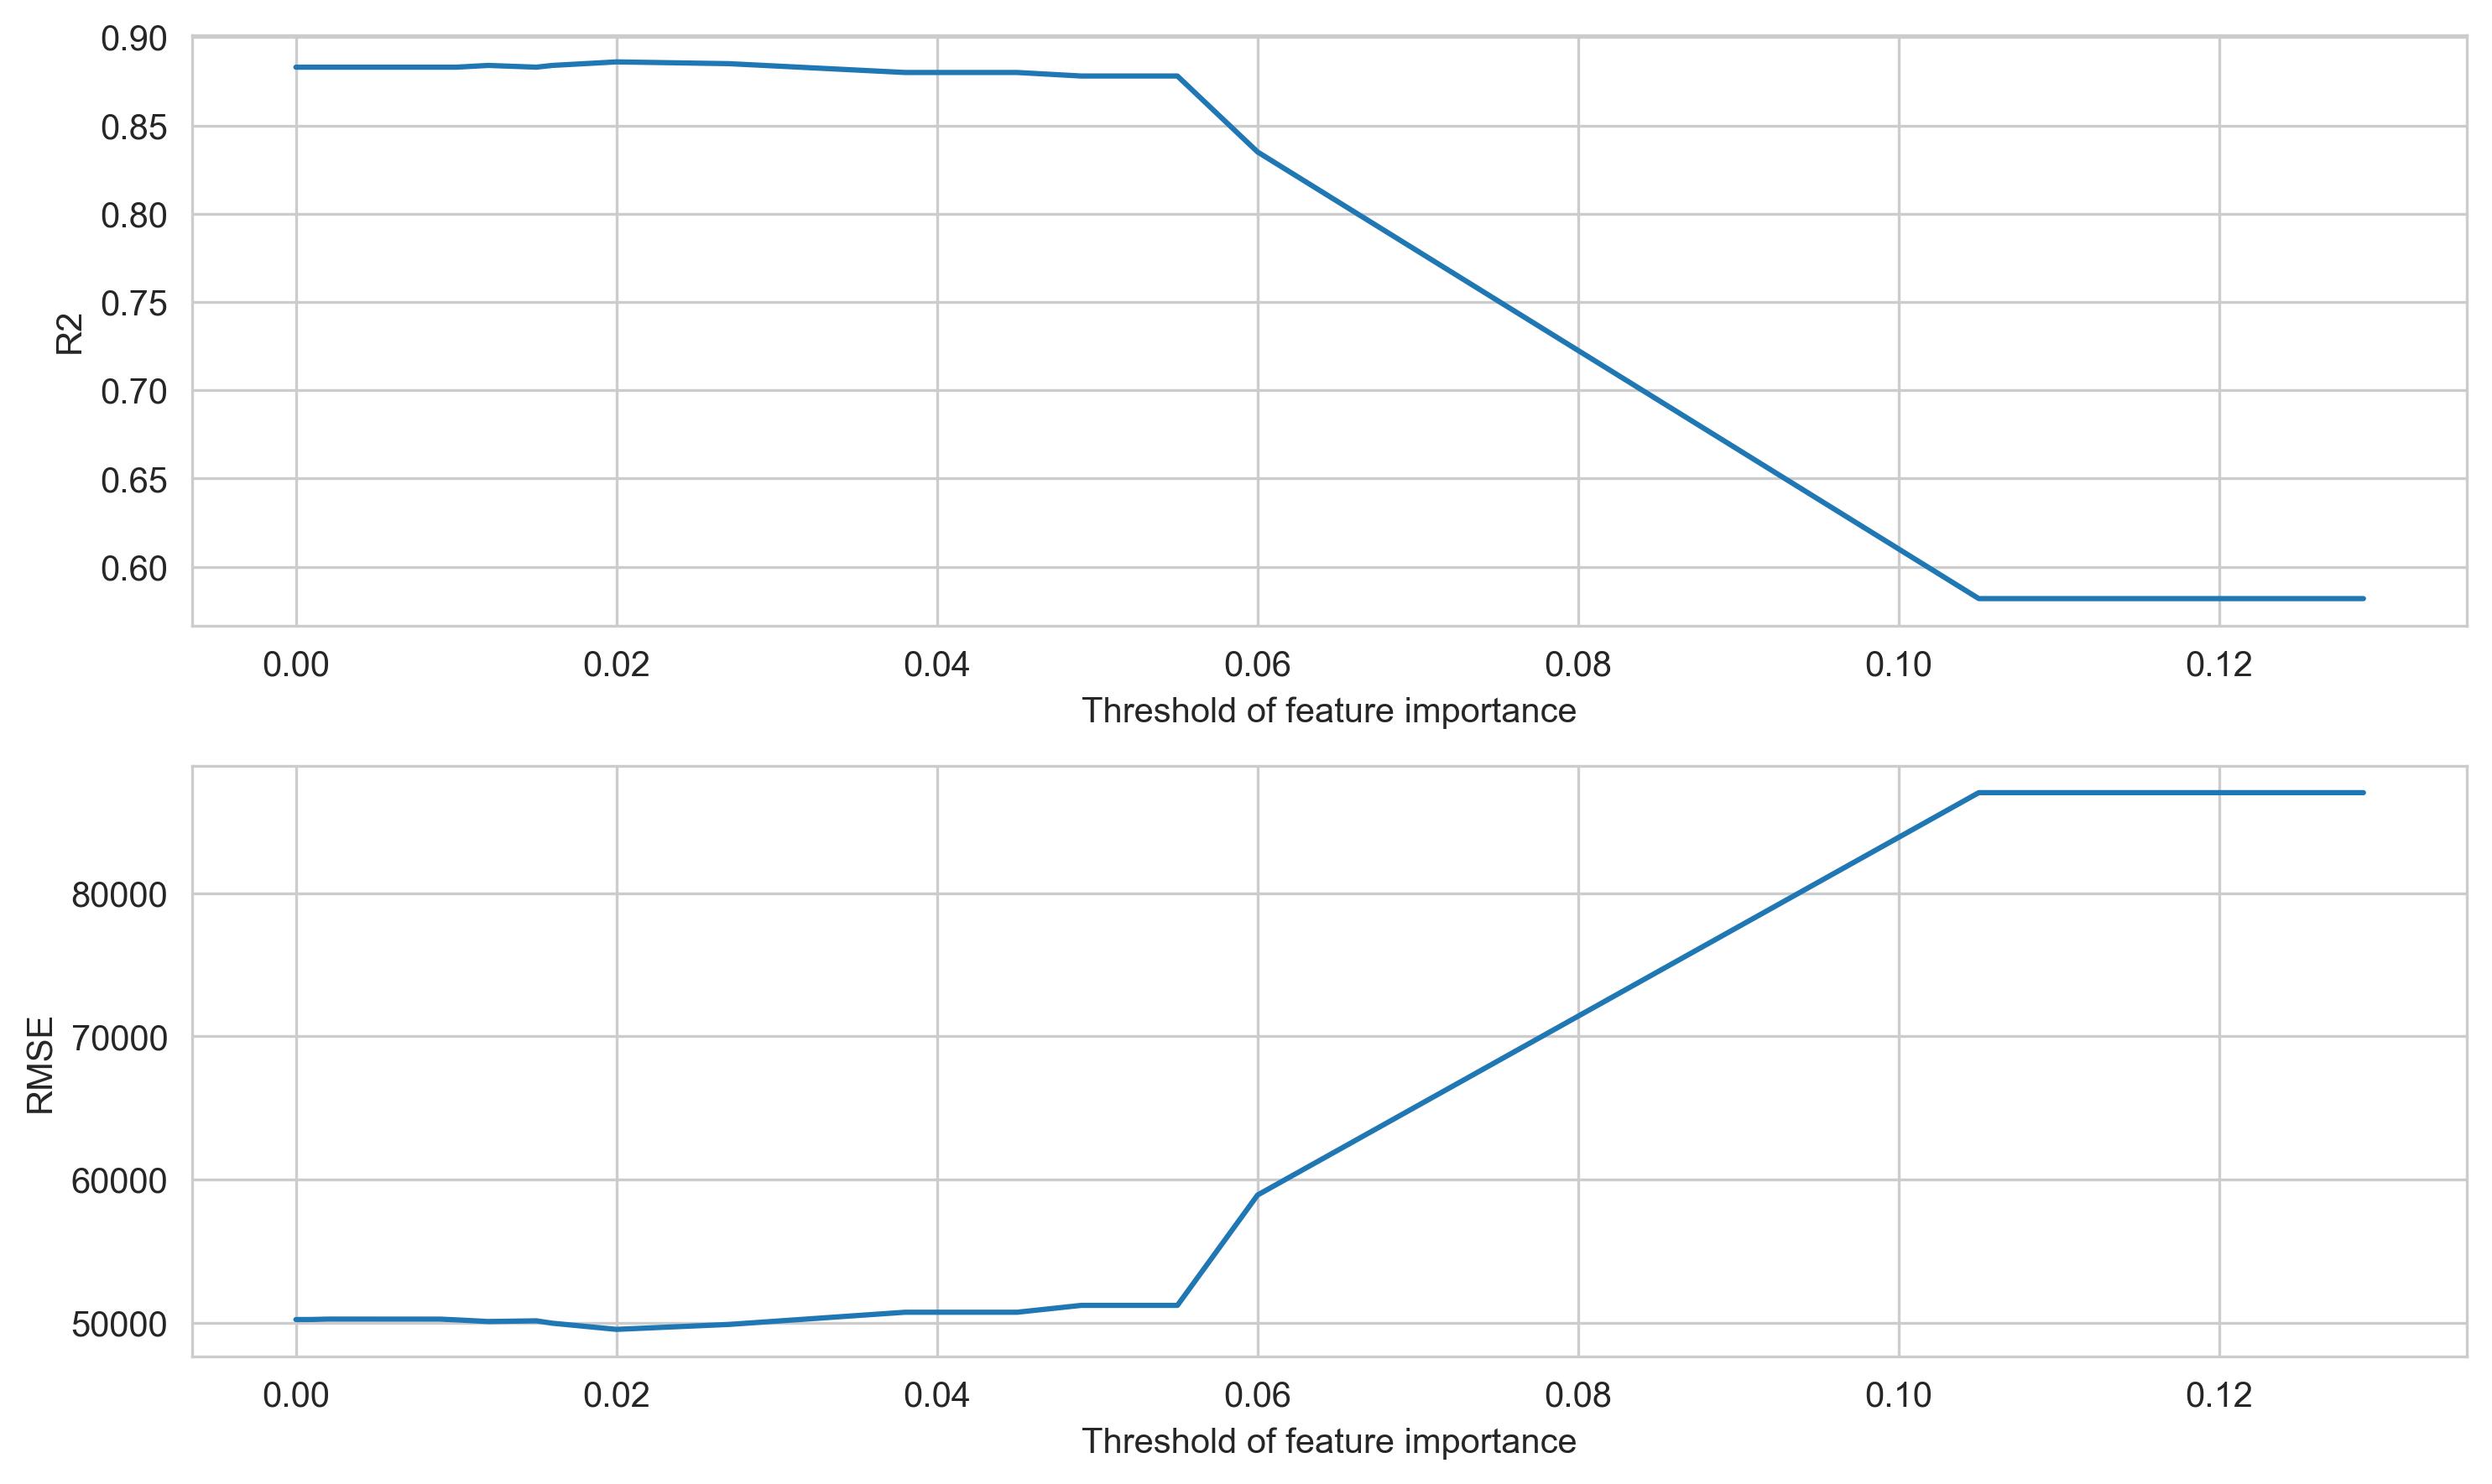

In [43]:
plot_scores_by_threshold(results_df)

The above plots show that the R2 value has a sudden decrease when the threshold of feature importance is around 0.06. Meanwhile the RMSE value has a sudden increase. To be more accurate, we find the threshold of feature importance that maximizes the R2 value and minimizes the RMSE value. 

In [44]:
results_df[results_df["R2"] == results_df["R2"].max()]

,Threshold,Number of Features,R2,RMSE
8,0.02,9,0.886,49556.332


In [45]:
results_df[results_df["RMSE"] == results_df["RMSE"].min()]

,Threshold,Number of Features,R2,RMSE
8,0.02,9,0.886,49556.332


It turns out when the threshold of feature importance is 0.02, the R2 value is maximized, and the RMSE value is minimized. There are 9 features selected. 

In [46]:
best_threshold = results_df[results_df["RMSE"] == results_df["RMSE"].min()]["Threshold"].values[0] 
best_threshold

0.02

In [47]:
important_features = select_important_features(X_train, y_train, best_threshold)

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


9 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


In [48]:
def keep_important_features(X, important_features):
    with open("important_feature_list", "wb") as fp:
        pickle.dump(important_features, fp)
    print(f"{len(important_features)} features are important.")
    print(important_features)
    X = X[important_features]
    return X 

In [49]:
X_train = keep_important_features(X_train, important_features)
X_train.head()

9 features are important.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


,longitude,latitude,housing_median_age,median_income,longitude_over_latitude,population_over_total_rooms,population_over_total_bedrooms,population_over_households,ocean_proximity_inland
0,-0.085055,0.474493,1.802160,-1.189034,0.656749,3.134813,4.127777,2.675156,1.436943
1,-1.290886,0.954125,1.068269,-0.929797,0.828809,0.890962,-0.198545,0.165600,-0.695922
2,0.786930,-0.844495,-1.051862,1.614041,-0.839319,0.121927,0.782017,0.931160,-0.695922
3,-0.095021,0.474493,1.639073,-0.964886,0.653108,0.672946,0.424717,0.940066,1.436943
4,-0.817523,1.378415,-1.051862,1.089898,1.507510,-0.371538,0.095545,0.218827,1.436943


In [50]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (12296, 9)
y_train shape: (12296, 1)
